## Style guides (remove before submitting)
1. PEP8 for python: https://peps.python.org/pep-0008
2. for jupyter notebook: https://github.com/spacetelescope/style-guides/blob/master/guides/jupyter-notebooks.md

## General TODO (remove before submitting)
1. Maybe add Raise errors?

## DOCSTRING convention example (according to Pep8) (remove before submitting)
**Short docstrings:**\
"""This is an example of a short docstring."""\
\
**Long docstrings:**\
"""\
Short description of the function (may be next to quotations above).\
\
Arguments:\
    parametername: What the parameter is\
    parametername2: what the parameter is\
\
Returns:\
    This is a description of what the function returns.\
"""

# Gillespie's Algorithm and Stochasticity in a SIR model

This code implements a Gillespie's algorithm (GA) to a SIR model where stochasticity is introduced.  

#### SIR Model
A SIR model is a description of the behavioral patterns of infectious disseases with the help of a set of Ordinary Differential Equations (ODEs). Depending on the dissease that's being modeled, there are different types of SIR models that can be implemented. The model that we use is divided into three categories:

1.  Susceptible; A group within the population that is susceptible to infection with the dissease.
2.  Infected; A group within the population that is currently infected with the dissease
3.  Recovered; A group that has recovered from an infection, we assume they cannot be infected again

The rate with which people transfer between these categories is described by parameters. The parameters we use are called the infection rate (beta) and recovery rate (gamma) that describe the flow of susceptible to infected (beta) and of infected to recovered (gamma). Additionally, birth and death rates are introduced to describe the effect of 'fresh' additions to the population to the susceptible pool and a chance of mortality at each category.

The set of ODEs describe how the populations within these categories change over time due to the applied parameters. 

### Gillespie's Algorithm
A Gillespie's Algorithm (GA) stochastically simulates discrete events from the equation it is applied to. In our application we used the so-called First Reaction Method where the rate at which an event occurs is passed to calculate how long it takes for the event to occur. To this determination, a random variable is attached to add stochasticity. The event that takes the least amount of time to occur is then executed, all other events are negated. The time that passed is updated to include the time it took for the event to occur and a new event is generated. This is repeated until the predetermined end-point is reached (such as an established end-time).

- TO DO: 
    - add ODE functions
    - add GA function 







## Imports

The following libraries where imported for further use in the code

* tabulate for ...
* numpy for use in numerical computing
* matplotlib for visualisation of data in plots
* pandas for ...
* fractions for ...
* solve_ivp for numerical integration of the SIR ODE functions
* bisect for ...

- TO DO:
    - Add explanations
    - Remove unused imports

In [91]:
#from tabulate import tabulate
#from fractions import Fraction

import bisect
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import operator
from scipy.integrate import solve_ivp

import networkx as nx
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
import ndlib.models.DiffusionModel as dm


## Define All Possible Events (test merge)


In [69]:
def sir_update(S, I, R, N, key):
    """Updates and returns SIRN populations according to given key."""

    if key == 'infection':
        S -= 1
        I += 1
        return S, I, R, N
    
    elif key == 'recovery': 
        R += 1
        I -= 1
        return S, I, R, N
    
    elif key == 'birth':
        S += 1
        N += 1
        return S, I, R, N
    
    elif key == 'death S':
        S -= 1
        N -= 1
        return S, I, R, N
    
    elif key == 'death I':
        I -= 1
        N -= 1
        return S, I, R, N
    
    elif key == 'death R':
        R -= 1
        N -= 1
        return S, I, R, N

## Implement GSP 

- Add a way to control noise level (gsp function)
    - Larger N reduces noise
    - average results on multiple simulations
    - reduce noise after simultaion: remove high frequency fluctuations

In [71]:
def gsp(sir, beta, gamma, mu, end):
    """
    Simulates disease spread using GA First Reaction Method.

    Arguments:
        sir: List of S, I, R and N populations.
        beta: Infection rate.
        gamma: Recovery rate.
        mu: Natural birth and death rate.
        end: Signifies end point of simulation in time.

    Returns:
        A tuple containing a list of time events and population data 
        over time.
    """

    S, I, R, N = sir
    t = 0
    
    t_events = []
    y_data = []
    
    while t <= end:
        
        # This queue collects the delta_t of each event at time t + delta_t
        event_queue = {}

        if S > 0 and I > 0 and N > 0:
            dt_infection = np.random.exponential(1/(beta*S*I/N))
            event_queue['infection'] = dt_infection

        if I > 0:
            dt_recovery = np.random.exponential(1/(gamma*I))
            event_queue['recovery'] = dt_recovery

        if N > 0:
            dt_birth = np.random.exponential(1/(mu*N))
            event_queue['birth'] = dt_birth

        if S > 0:
            dt_death_S = np.random.exponential(1/(mu*S))
            event_queue['death S'] = dt_death_S

        if I > 0:
            dt_death_I = np.random.exponential(1/(mu*I))
            event_queue['death I'] = dt_death_I

        if R > 0:
            dt_death_R = np.random.exponential(1/(mu*R))
            event_queue['death R'] = dt_death_R

        # Select the event with the smallest delta_t, this event will be carried out, the rest is omitted
        sorted_queue = dict(sorted(event_queue.items(), 
                                   key=lambda item: item[1]))
        first_event_key, first_event_time = list(sorted_queue.items())[0]
        
        # Updates the current time with delta_t
        t += first_event_time
        t_events.append(t)

        # Handle each type of event
        S, I, R, N = sir_update(S, I, R, N, first_event_key)

        y_data.append([S, I, R])
    
    return (t_events, y_data)

## Run Stochastic Simulation

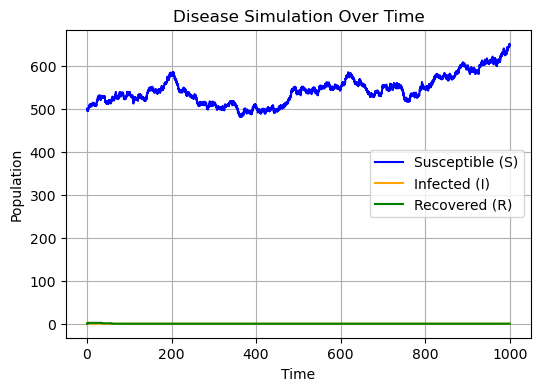

In [72]:
def run_simulation(sir, beta, gamma, mu, t_span):
    """
    Runs the GA stochastic disease simulation and plots the results.

    Arguments:
        sir: List of S, I, R and N populations.
        beta: Infection rate.
        gamma: Recovery rate.
        mu: Natural birth and death rate.
        t_span: Maximum duration of the GA simulation.
    """

    t_events, y_data = gsp(sir, beta, gamma, mu, t_span)

    y_data = np.array(y_data)

    S = y_data[:, 0]
    I = y_data[:, 1]
    R = y_data[:, 2]

    plt.figure(figsize=(6, 4))
    plt.plot(t_events, S, label='Susceptible (S)', color='blue')
    plt.plot(t_events, I, label='Infected (I)', color='orange')
    plt.plot(t_events, R, label='Recovered (R)', color='green')
    plt.xlabel('Time')
    plt.ylabel('Population')
    plt.title('Disease Simulation Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()


# Parameters
N = 500
S = N - 1
I = N - S
R = 0
sir = [S, I, R, N]

beta = 0.6
gamma = 0.1
mu = 0.01
parameters = [beta, gamma, mu]

t_span = 1000

run_simulation(sir, beta, gamma, mu, t_span)

## Run Deterministic Model

To do:

- Add similarity score between stochastic and derministic model.

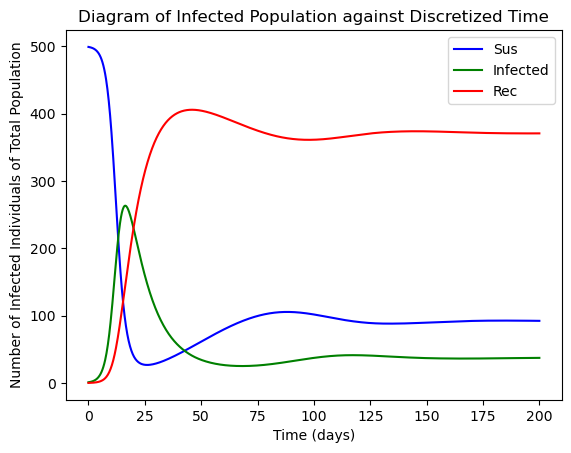

In [73]:
def calc_ode(t, sir, parameters, N):
    """Calculates and returns the change in sir populations over time."""
    
    beta, gamma, mu = parameters
    S, I, R = sir

    dSdt = (mu*N) - ((beta*S*I)/N) - (mu*S)
    dIdt = ((beta*S*I)/N) - (gamma*I) - (mu*I)
    dRdt = (gamma*I) - (mu*R)

    return [dSdt, dIdt, dRdt]


def plot_sir_det(time, S, I, R):
    """Plots the deterministic sir model."""

    plt.plot(time, S, label='Sus', color='b')
    plt.plot(time, I, label='Infected', color='g')
    plt.plot(time, R, label='Rec', color='r')
    plt.xlabel('Time (days)')
    plt.ylabel('Number of Infected Individuals of Total Population')
    plt.legend()
    plt.title('Diagram of Infected Population against Discretized Time')
    plt.show()


def run_sir_det(sir, parameters, N, t_span):
    """Runs the deterministic sir model with passed initial values.
    
    Arguments:
        sir: List of S, I, R and N populations.
        parameters: list containg recovery, infection and 
                    birth/death rate
        N: Total initial population
        t_span: Timespan in which the model is ran

    Returns: 
        Timespan used to model sir and population sizes of S, I and R.
    """

    # Time measurement with 1000 samples, equally spaced between 0 and t_span
    time = np.linspace(0, t_span, 1000)

    sir_integration = solve_ivp(calc_ode, [time[0], time[-1]], sir, 
                                args=(parameters, N), t_eval=time)
    S, I, R = sir_integration.y

    #plot_sir_det(time, S, I, R)

    return time, S, I, R


# Parameters for infection, recovery and death rate
beta = 0.6
gamma = 0.1
mu = 0.01
parameters = [beta, gamma, mu]

# Intitial population densities
N = 500
S0 = N - 1
I0 = N - S0
R0 = 0
sir_det = [S0, I0, R0]

t_span = 200

# The semi-colon prevents the array from being printed in cell
time, S, I, R = run_sir_det(sir_det, parameters, N, t_span);
plot_sir_det(time, S, I, R)

## Look at variance

- Plot results

- Delete print statements (not yet)

In [ ]:
np.random.seed(35)


def generate_parameters(num_samples, lower_ratio=0.45, upper_ratio=0.55, 
                        beta_range=(0.1, 0.9), gamma_range=(0.1, 0.9)):
    """
    Generates beta and gamma pairs randomly to calculate their R0 values. 
    Ensures ratio of R0 values  falls within specified bounds.
    
    Arguments:
        num_samples: Total number of beta/gamma pairs to generate.
        lower_ratio: Lower bound for the ratio of R0 values.
        upper_ratio: Upper bound for the ratio of R0 values.
        beta_range: Range for generated beta values.
        gamma_range: Range for generated gamma values.
    
    Returns:
        A list of the beta gamma pairs and a list of the generated 
        R0 values.
    """
    
    # Initialize ratio of R0 values smaller and larger than 1.
    ratio = 0

    while ratio < lower_ratio or ratio > upper_ratio:

        # only same random generator
        betas = np.random.uniform(beta_range[0], beta_range[1], num_samples)
        gammas = np.random.uniform(gamma_range[0], gamma_range[1], num_samples)

        beta_gamma_pairs = list(zip(betas, gammas))
        R0_vals = [beta / gamma for beta, gamma in beta_gamma_pairs]

        # Calculate the ratio of R0 values < 1 and > 1
        num_below_one = np.sum(np.array(R0_vals) < 1)
        num_above_one = np.sum(np.array(R0_vals) > 1)
        ratio = num_below_one/(num_above_one + 1e-10)  # Avoid division by zero (this is hardcoding, another way?)

    R0_vals
    print("Beta/gamma pairs: " + str(beta_gamma_pairs))
    print("R0 values: " + str(R0_vals))
    print("Ratio: " + str(ratio))
    
    return beta_gamma_pairs, R0_vals


def parameter_sweep(sir, pairs, mu, num_runs):
    """
    Performs a parameter sweep over the SIR model simulation to analyze 
    the impact of varying beta and gamma values on the maximum number of 
    infected individuals.

    Arguments:
        sir: List of S, I, R and N populations.
        pairs: List of beta-gamma tuples to test in SIR model.
        mu: Natural birth and death rate.
        num_runs: Number of simulation runs per beta-gamma pair tuples.
    
    Returns:
        A list of variances and covariances of the maximum infected 
        values for each beta-gamma pair.
    """
    
    variances = []
    covariances = []

    for beta, gamma in pairs:
        
        # For variance
        max_I_vals = []

        # For covariance
        S_vals= []
        I_vals = []
        
        # Run simulation n times for each (beta, gamma) pair.
        for _ in range(num_runs):

            result = gsp(sir, beta, gamma, mu, t_span)
            y_data = np.array(result[1])

            S = y_data[:, 0]
            I = y_data[:, 1]
            R = y_data[:, 2]

            S_vals.extend(S)
            I_vals.extend(I)

            # Extract max I value from each run.
            max_I_vals.append(np.max(I))

        # Variance for each (beta, gamma) pair after n runs is recorded.
        variances.append(np.var(max_I_vals))
        covariance_matrix = np.cov(S_vals, I_vals)
        covariances.append(covariance_matrix[0, 1])

    return variances, covariances


def plot_R0_vs_variance(R0_vals, variances):
    """
    Plots R0 values against variances of maximum infected individuals.
    """

    plt.figure(figsize=(7, 4))
    plt.scatter(R0_vals, variances, color='green', edgecolor='black')

    plt.xlabel('R0 Values')
    plt.ylabel('Variance of Max Infected')
    plt.title('R0 Values vs Variance of Maximum Infected Individuals')
    #plt.axhline(0, color='gray', linestyle='--')  # Optional: Add a horizontal line at y=0
    plt.grid(True)
    plt.xlim(0, 5)
    plt.tight_layout()
    plt.show()


def plot_R0_vs_covariances(R0_vals, covariances):
    """
    Plots R0 values against covariances of S and I across different 
    parameter pairs.
    """

    plt.figure(figsize=(7, 4))
    plt.scatter(R0_vals, covariances, color='green', edgecolor='black')

    plt.xlabel('R0 Values')
    plt.ylabel('S, I Covariance')
    plt.title('R0 Values vs Covariances of S and I')
    #plt.axhline(0, color='gray', linestyle='--')  # Optional: Add a horizontal line at y=0
    plt.grid(True)
    plt.xlim(0, 5)
    plt.tight_layout()
    plt.show()


# Define number of beta/gamma pairs.
num_pairs = 50

# Define number of runs per beta/gamma pair.
num_runs = 10

# Generate Parameters
sample_pairs, sample_R0_vals = generate_parameters(num_pairs)

# Calculate variances
variances, covariances = parameter_sweep(sir, sample_pairs, mu, num_runs)

# Combine and sort by R0 for variance analysis
var_combined = list(zip(sample_R0_vals, variances))
sorted_var_combined = sorted(var_combined)
sorted_R0_vals, sorted_variances = zip(*sorted_var_combined)

# Combine and sort by R0 for variance analysis
covar_combined = list(zip(sample_R0_vals, covariances))
sorted_covar_combined = sorted(covar_combined)
sorted_R0_vals, sorted_covariances = zip(*sorted_covar_combined)


plot_R0_vs_variance(sorted_R0_vals, sorted_variances)
plot_R0_vs_covariances(sorted_R0_vals, sorted_covariances)

## Calculate the Mean accross multiple runs 
TO DO: change deterministic to roll with same parameters

In [74]:
def gsp_mean(runs, t_span, sir, parameters):
    """
    """

    beta, gamma, mu = parameters

    # calculates how large the steps should be in between time steps    
    t_steps = t_span/ 1000
 
    # end excludes end so include t_steps. steps are spacing between values
    fixed_steps = np.round(np.arange(0, t_span + t_steps, t_steps), 2)

    # store data from run at those fixed time steps 
    results = {
        'time': fixed_steps.tolist(),
        'S': {round(step, 4): [] for step in fixed_steps},
        'I': {round(step, 4): [] for step in fixed_steps},
        'R': {round(step, 4): [] for step in fixed_steps},
        'N': {round(step, 4): [] for step in fixed_steps}
        }
    
    results_mean = {
        'S': [],
        'I': [],
        'R': [],
        'N': []
        }
    
    results_stdev = {
        'S': [],
        'I': [],
        'R': [],
        'N': []
        }

    # Stores the peak number of Infected and equivalent timepoint for every run
    peak_infected = []

    I_max = 0
    t_max = 0

    for run in range(runs):
        # get data from run
        t_events , y_data = gsp(sir, beta, gamma, mu, t_span)

        I_max = 0
        t_max = 0

        # finds for which values of steps in fixed_steps what the closest (lower) is in t_events.
        for steps in fixed_steps:

            #round the steps similarly to the dictionary
            steps = round(steps, 4)

            #returns where a value should be inserted
            position_value = bisect.bisect_right(t_events, steps)

            #want lowest closest value position, but position can be 0 or higher than max (t_span)
            if position_value > 0:
                position_value -= 1

            S, I, R = y_data[position_value]

            if I > I_max:
                I_max = I
                t_max = t_events[position_value]

            # Appends the corresponding values to the correct place on the timeline
            results['S'][steps].append(S)
            results['I'][steps].append(I)
            results['R'][steps].append(R)
            results['N'][steps].append(S + I + R)
            
        peak_infected.append([t_max, I_max])

    #access every fixed step
    # access all entries for S, I , R and N in the fixed steps and store mean values in a dictionary
    for steps in fixed_steps:
        
        results_mean['S'].append(np.mean(results['S'][steps]))
        results_mean['I'].append(np.mean(results['I'][steps]))
        results_mean['R'].append(np.mean(results['R'][steps]))
        results_mean['N'].append(np.mean(results['N'][steps]))

        results_stdev['S'].append(np.std(results['S'][steps]))
        results_stdev['I'].append(np.std(results['I'][steps]))
        results_stdev['R'].append(np.std(results['R'][steps]))
        results_stdev['N'].append(np.std(results['N'][steps]))
    
    return results, results_mean, results_stdev, peak_infected


def plot_mean(results, results_mean, results_stdev, sir):
   
    S, I, R, N = sir
    sir_det = [S, I, R]

    S_mean = results_mean['S']
    I_mean = results_mean['I']
    R_mean = results_mean['R']
    time = results['time']

    time_2, S, I, R = run_sir_det(sir_det, parameters, N, t_span)
    
    plt.plot(time, S_mean, label='S mean', color='blue')
    plt.plot(time, I_mean, label='I mean', color='red')
    plt.plot(time, R_mean, label='R mean', color='green')
    plt.plot(time_2, S, label='S deterministic', color='blue', 
             linestyle='dashed')
    plt.plot(time_2, I, label='I deterministic', color='red', 
             linestyle='dashed')
    plt.plot(time_2, R, label='R deterministic', color='green', 
             linestyle='dashed')

    time_steps_S = []
    time_steps_I = []
    time_steps_R = []
    S_values = []
    I_values = []
    R_values = []

    for time_step, values in results['S'].items():
        for value in values:
            time_steps_S.append(time_step)
            S_values.append(value)
    
    for time_step, values in results['I'].items():
        for value in values:
            time_steps_I.append(time_step)
            I_values.append(value)

    for time_step, values in results['R'].items():
        for value in values:
            time_steps_R.append(time_step)
            R_values.append(value)

    plt.scatter(time_steps_S, S_values, alpha=0.03, linewidths=0, 
                color='blue', marker='o', label='S values', s=1)
    plt.scatter(time_steps_I, I_values, alpha=0.03, linewidths=0, 
                color='red', marker='o', label='I values', s=1)
    plt.scatter(time_steps_R, R_values, alpha=0.03, linewidths=0, 
                color='green', marker='o', label='R values', s=1)

    plt.xlabel('Time (days)')
    plt.ylabel('Mean Number of Infected Individuals of Total Population')
    plt.legend()
    plt.title('Diagram of Population against Discretized Time (mean)')
    plt.show()

    return


# Initial conditions with a population of 500 people
N = 500
S = N - 1
I = N - S
R = 0
sir = [S, I, R, N]

beta = 0.6
gamma = 0.1
mu = 0.05
parameters = [beta, gamma, mu]

t_span = 100

runs = 100

results, results_mean, results_stdev, _ = gsp_mean(runs, t_span, sir, parameters);
#plot_mean(results, results_mean, results_stdev, sir)

## R0 vs Extinction Events

In [ ]:
def generate_large_R0(num_samples, R0_range=(1.1, 5), gamma_value=0.1):
    """
    Generates systematic beta and gamma pairs such that the R0 values range from 1.1 to 5.
    
    Parameters:
        num_samples (int): Number of beta/gamma pairs to generate.
        R0_range (tuple): Range for R0 values.
        gamma_value (float): Fixed value for gamma (to systematically calculate beta).
    
    Returns:
        list: List of (beta, gamma) pairs.
        list: List of R0 values.
    """
    # Generate evenly spaced R0 values within the specified range
    R0_vals = np.linspace(R0_range[0], R0_range[1], num_samples)
    
    # Use a fixed gamma value, and calculate corresponding beta = R0 * gamma
    gammas = np.full(num_samples, gamma_value)
    betas = R0_vals*gammas  # beta = R0 * gamma

    beta_gamma_pairs = list(zip(betas, gammas))

    # Optional: print for debugging
    print("Beta/gamma pairs: " + str(beta_gamma_pairs))
    print("R0 values: " + str(R0_vals))
    
    return beta_gamma_pairs, R0_vals


def count_R0_extinctions(pairs, num_runs):

    extinction_list = []

    for beta, gamma in pairs:
    
        num_extinctions = 0
    
        for _ in range(num_runs):


                result = gsp(sir, beta, gamma, mu, t_span)
                y_data = np.array(result[1])

                I = y_data[:, 1]

                mean = np.mean(I)

                print(mean)


                if mean < 1e-2:  # Treat any value below a small threshold as extinction:
                    
                    num_extinctions += 1

                
        
        extinction_list.append(num_extinctions)

    
    return extinction_list
        

def plot_results_R0(num_pairs, num_runs):
    
    sample_pairs, sample_R0_vals = generate_large_R0(num_pairs)
    R0_extinctions = count_R0_extinctions(sample_pairs, num_runs)

    # Sort R0 values and corresponding extinctions
    R0_extinction_pairs = list(zip(sample_R0_vals, R0_extinctions))
    sorted_R0_extinction_pairs = sorted(R0_extinction_pairs)

    sorted_R0_vals, sorted_extinctions = zip(*sorted_R0_extinction_pairs)

    # Convert to numpy arrays for easy indexing
    sorted_R0_vals = np.array(sorted_R0_vals)
    sorted_extinctions = np.array(sorted_extinctions)

    # Bin the R0 values (for example, in intervals of 0.1)
    bins = np.arange(min(sorted_R0_vals), max(sorted_R0_vals), 0.2)
    bin_indices = np.digitize(sorted_R0_vals, bins)

    # Average extinctions within each bin
    binned_extinctions = [np.mean(sorted_extinctions[bin_indices == i]) 
                          for i in range(1, len(bins))]

    # Plotting
    plt.bar(bins[:-1], binned_extinctions, width=0.1)
    plt.xlabel("R0 Value")
    plt.ylabel("Average Extinctions")
    plt.title("Average Extinctions vs. R0 Value")
    plt.show()


num_pairs = 20
num_runs = 50
mu = 0.0001

plot_results_R0(num_pairs, num_runs)

## N vs Extinction Events

In [ ]:
def generate_populations(num_pops):
    populations = []
    
    # Evenly distributes populations from 100 to 10,000.
    S_0 = np.linspace(100, 10000, num_pops)

    for i in range(num_pops):
        S = S_0[i]
        I = 1
        R = 0
        N = S + I
        sir = (S, I, R, N)
        populations.append(sir)
    
    return populations


def count_N_extinctions(num_pops, num_runs):
    populations = generate_populations(num_pops)
    extinction_list = []

    for pop in populations:
        num_extinctions = 0
        for _ in range(num_runs):
            result = gsp(pop, beta, gamma, mu, t_span)
            y_data = np.array(result[1])
            I = y_data[:, 1]
            mean = np.mean(I)

            # Treats any value below a small threshold as extinction.
            if mean < 1e-3:
                num_extinctions += 1
        
        extinction_list.append(num_extinctions)
    
    return extinction_list


def plot_results_N(num_pops, num_runs):
    sample_pops = generate_populations(num_pops)
    N_extinctions = count_N_extinctions(num_pops, num_runs)

    # Sorts population sizes and corresponding extinctions.
    N_extinction_pairs = list(zip(sample_pops, N_extinctions))
    sorted_N_extinction_pairs = sorted(N_extinction_pairs)

    sorted_pops, sorted_extinctions = zip(*sorted_N_extinction_pairs)

    # Convert to numpy arrays for easy indexing
    sorted_pops = np.array(sorted_pops)
    sorted_extinctions = np.array(sorted_extinctions)

    # Bin the population sizes more sensibly with a larger bin size
    bins = np.arange(min(sorted_pops[:, 0]), max(sorted_pops[:, 0]) + 1, 300)  # Increase bin size to 1000
    bin_indices = np.digitize(sorted_pops[:, 0], bins)

    # Average extinctions within each bin
    binned_extinctions = [np.mean(sorted_extinctions[bin_indices == i]) for i in range(1, len(bins))]

    # Plotting
    plt.bar(bins[:-1], binned_extinctions, width=np.diff(bins), align='edge')
    plt.xlabel("N")
    plt.ylabel("Average Extinctions")
    plt.title("Average Extinctions vs. N (with adjusted bin size)")
    plt.show()


# Parameters
beta = 0.4
gamma = 0.1
mu = 0.0001

num_pops = 20
num_runs = 50

plot_results_N(num_pops, num_runs)

## Extinctions as a Function of R0 and N

In [ ]:
def plot_results_R0_N(num_pairs, num_pops, num_runs):
    # Generate R0 pairs
    sample_pairs, sample_R0_vals = generate_large_R0(num_pairs)

    # Generate populations
    populations = generate_populations(num_pops)

    # Count extinctions for each combination of R0 and N
    extinction_data = []

    for (beta, gamma), R0 in zip(sample_pairs, sample_R0_vals):
        
        for pop in populations:
            num_extinctions = 0
            
            for _ in range(num_runs):
                result = gsp(pop, beta, gamma, mu, t_span)
                y_data = np.array(result[1])
                I = y_data[:, 1]
                mean = np.mean(I)
                
                if mean < 1e-2:  # Treat any value below a small threshold as extinction
                    num_extinctions += 1

            # Store results: (N, R0, num_extinctions)
            N = pop[0] + pop[1] + pop[2]  # S + I + R
            extinction_data.append((N, R0, num_extinctions))

    # Convert to numpy array for easier indexing
    extinction_data = np.array(extinction_data)

    # Separate the data for plotting
    N_values = extinction_data[:, 0]
    R0_values = extinction_data[:, 1]
    extinction_counts = extinction_data[:, 2]

    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    scatter = ax.scatter(N_values, R0_values, extinction_counts, c=extinction_counts, cmap='viridis')
    
    ax.set_xlabel('Population Size (N)')
    ax.set_ylabel('R0 Value')
    ax.set_zlabel('Number of Extinctions')
    ax.set_title('Interaction between R0 and N in Extinctions')
    
    # Add color bar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Number of Extinctions')

    plt.show()


# Parameters
num_pairs = 20
num_pops = 20
num_runs = 20
mu = 0.0001

# Execute the plotting function
plot_results_R0_N(num_pairs, num_pops, num_runs)

## Stochastic Resonance

In [ ]:
def stoc_res_R0(num_samples, R0_range=(1, 10), gamma_value=0.1):
    
    # Generates a list of R0 values, evenly spaced, rounded by 2 decimals.
    R0_values = np.round(np.linspace(R0_range[0], R0_range[1], num_samples), 2)
    beta_values = []
    gamma_values = []

    for value in R0_values:
        beta_values.append(np.round((value * gamma_value), 2))
        gamma_values.append(gamma_value)

    beta_gamma_pairs = list(zip(beta_values, gamma_values))
    #print(beta_gamma_pairs)
    #print(R0_values, beta_values)
    # R0 values is a list of n_samples R0 and beta of n_sample amount, gamma equal

    return beta_gamma_pairs

def stoc_res(sir, t_span, num_samples, mu):
    """
    Peak infected and peak_det are lists containing all sets of peak 
    infected values.
    """

    beta_gamma_pairs = stoc_res_R0(num_samples)

    peak_det = []
    bg = []
    snr = []

    # mean time results for gsp list of mean for each b-g pair
    mean_time = []
    stdev_time = []

    for beta, gamma in beta_gamma_pairs:
        parameters = [beta, gamma, mu]
        runs_stoc = 10
        _, _, _, peak_infected = gsp_mean(runs_stoc, t_span, sir, parameters)

        # Calculates the mean and stdev for peak infected time in gsp
        time = [t[0] for t in peak_infected]
        mean_time.append(np.mean([time]))
        mean_time_gsp = np.mean([time])
        stdev_time.append(np.std([time]))
        
        # Unpacks and reassign sir for deterministic model.
        S, I, R, N = sir
        sir_det = S, I , R
        time_det, _, I_det, _ = run_sir_det(sir_det, parameters, N, 
                                                    t_span)

        # Finds maximum values for deterministic model and stores them.
        I_max = max(I_det)
        t_max_index = np.where(I_det == I_max)
        t_max = time_det[t_max_index][0]
        peak_det.append([t_max])

        bg.append(beta/gamma)

        snr.append(t_max/ mean_time_gsp)


    # have peaks for det
    # have peaks for gsp mean
    # have peaks for gsp stdev
    return mean_time, stdev_time, peak_det, bg, snr

def plot_stoc_peak(mean_time, peak_det, bg):
    """
    TO DO: possibly add stdev error bars, substract mean det from mean 
    gsp, but will go into 0."""

    plt.plot(bg, peak_det, label='peak I time det', color='green')
    plt.plot(bg, mean_time, label='peak I time stoc', color='blue')
    plt.xlabel('R0')
    plt.ylabel('Time of peak I')
    plt.legend()
    plt.title('Time to reach peak in Infected population for different R0 values')
    plt.show()


    return

def plot_stoc_snr(bg, snr):
    """
    TO DO: possibly add stdev error bars, substract mean det from mean 
    gsp, but will go into 0."""

    plt.plot(bg, snr, label='SNR', color='red')
    plt.xlabel('R0')
    plt.ylabel('Signal to Noise ratio')
    plt.legend()
    plt.title('SNR ratio for peak in infected population for different R0 values')
    plt.show()


    return

num_samples = 100
#stoc_res_R0(num_samples, R0_range=(0, 5), gamma_value=0.1)

# Initial conditions with a population of 500 people
N = 500
S = N - 1
I = N - S
R = 0
sir = [S, I, R, N]

mu = 0.001

t_span = 200

mean_time, stdev_time, peak_det, bg, snr = stoc_res(sir, t_span, num_samples, mu)
plot_stoc_peak(mean_time, peak_det, bg)
plot_stoc_snr(bg, snr)

## Mean for different N populations

In [16]:
def plot_means_for_different_Ns(N_values, num_runs, t_span, parameters):
    for N in N_values:
        # Generate initial conditions based on N
        sir = (N - 1, 1, 0, N)  # S, I, R, N

        # Get results for the current N
        _, results_mean, _, _ = gsp_mean(num_runs, t_span, sir, parameters)

        # Plot the mean infected population over time
        plt.plot(results_mean['I'], label=f'N = {N}')

    plt.xlabel('Time')
    plt.ylabel('Mean Infected Population')
    plt.title('Mean Infected Population for Different Values of N')
    plt.legend()
    plt.show()


N_values = [100, 500, 1000, 1500]  # Example N values
num_runs = 50
t_span = 1000
beta = 0.4
gamma = 0.2
mu = 0.01

parameters = (beta, gamma, mu)

plot_means_for_different_Ns(N_values, num_runs, t_span, parameters)

## Barabasi Albert Network

In [79]:
def barabasi_albert(N, m, beta, gamma, I0, t_span):
    """
    A barabasi-Albert network generates a scale-free network where some 
    nodes have more connections than others.

    New nodes are more likely to connect to nodes with more existing
    connections.
    """

    ba_graph = nx.barabasi_albert_graph(N, m)

    model = ep.SIRModel(ba_graph)

    config = mc.Configuration()
    config.add_model_parameter('beta', beta)  
    config.add_model_parameter('gamma', gamma)  
    config.add_model_parameter("fraction_infected", I0)  

    model.set_initial_status(config)

    iterations = model.iteration_bunch(t_span)

    
    y_data = []  

    for iteration in iterations:
        status = iteration['status']
        
        S_count = 0
        I_count = 0
        R_count = 0
        
        for _, state in status.items():
            if state == 0:  
                S_count += 1
            elif state == 1:  
                I_count += 1
            elif state == 2:  
                R_count += 1
        
       
        y_data.append({'S': S_count, 'I': I_count, 'R': R_count})

    return iterations, y_data  


def ba_parameter_sweep(N, m, beta, gamma, I0,  num_runs, num_pairs):

    pairs = generate_parameters(num_pairs)

    for pair in pairs:
        beta, gamma = pair

        iterations, y_data = barabasi_albert(N, m, beta, gamma, I0,  num_runs)

    y_data = []  

    for iteration in iterations:
        status = iteration['status']
        
        S_count = 0
        I_count = 0
        R_count = 0
        
        for _, state in status.items():
            if state == 0:  
                S_count += 1
            elif state == 1:  
                I_count += 1
            elif state == 2:  
                R_count += 1
        
        y_data.append({'S': S_count, 'I': I_count, 'R': R_count})

    return iterations, y_data  



N = 1000  
# Number of edges for a new node
m = 5

beta = 0.3
gamma = 0.1
I0 = 0.05

t_span = 200

results = barabasi_albert(N, m, beta, gamma, I0, t_span)
print(results)


([{'iteration': 0, 'status': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 1, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 1, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 1, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 1, 78: 0, 79: 0, 80: 1, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 1, 90: 0, 91: 0, 92: 0, 93: 0, 94: 1, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 1, 102: 1, 103: 0, 104: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 0, 119: 0, 120: 0, 121: 0, 122: 0, 123: 0, 124: 0, 125: 0, 126: 0, 127: 0, 128: 0, 129: 0, 130: 0, 131: 0, 132: 0, 133: 0, 134: 0, 

## SIR Sweep on Barabasi Albert network model

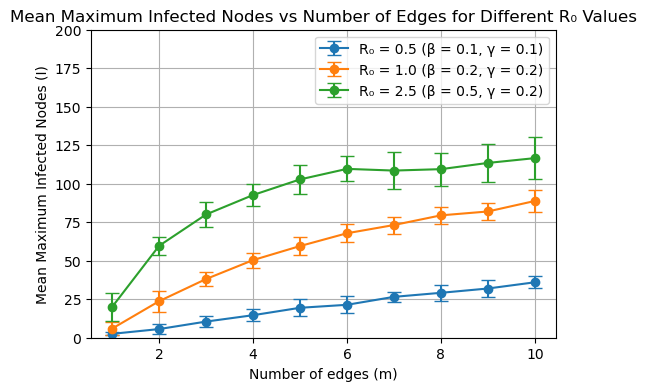

In [88]:
def ba_m_sweep(N, edges, beta, gamma, I0, t_span, num_runs):
    mean_max_values = []
    std_max_values = []

    for m in edges:
        max_I_values = []
        
        for _ in range(num_runs):  
            _, y_data = barabasi_albert(N, m, beta, gamma, I0, t_span)
            
            I_values = [data['I'] for data in y_data]
            
            # Get the maximum infected value in the current run
            max_I = max(I_values) if I_values else 0
            max_I_values.append(max_I)
        
        mean_max_I = np.mean(max_I_values) if max_I_values else 0
        std_max_I = np.std(max_I_values) if max_I_values else 0
        
        mean_max_values.append(mean_max_I)
        std_max_values.append(std_max_I)
    
    return mean_max_values, std_max_values


def plot_ba_m_sweep(N, edges, beta_values, gamma_values, I0, t_span, num_runs):
    plt.figure(figsize=(6, 4))
    
    for beta, gamma in zip(beta_values, gamma_values):
        
        mean_max_values, std_max_values = ba_m_sweep(N, edges, beta, gamma, I0, t_span, num_runs)
        
        R0 = beta/gamma
        label = f'R₀ = {R0:.1f} (β = {beta:.1f}, γ = {gamma:.1f})'
        
        plt.errorbar(edges, mean_max_values, yerr=std_max_values, fmt='-o', capsize=5, label=label)
    
    plt.xlabel("Number of edges (m)") 
    plt.ylabel("Mean Maximum Infected Nodes (I)")
    plt.title("Mean Maximum Infected Nodes vs Number of Edges for Different R₀ Values")
    plt.legend()  
    plt.grid(True)
    plt.ylim(0, N)  
    plt.show()


def ba_m_vs_R0(N, edges, I0, t_span, num_runs, R0_values, gamma_values):
    beta_values = [R0 * gamma for R0, gamma in zip(R0_values, gamma_values)]
    
    plot_ba_m_sweep(N, edges, beta_values, gamma_values, I0, t_span, num_runs)


N = 200
edges = np.arange(1, 11, 1)
R0_values = [0.5, 1.0, 2.5] 
gamma_values = [0.1, 0.2, 0.2]
I0 = 0.01
t_span = 50
num_runs = 50

ba_m_vs_R0(N, edges, I0, t_span, num_runs, R0_values, gamma_values)



## Watts-Strogatz

In [83]:
def watts_strogatz(N, k, p, beta, gamma, I0, t_span):
    """
    A Watts-Strogatz network model generates small-world networks with 
    short average path lengths between nodes and high cluster densities.
    """

    ws_graph = nx.watts_strogatz_graph(N, k, p)

    # Configure the diffusion model (e.g., SIR)
    model = ep.SIRModel(ws_graph)

    # Model configuration
    config = mc.Configuration()
    config.add_model_parameter('beta', beta)  # Infection rate
    config.add_model_parameter('gamma', gamma)  # Recovery rate
    config.add_model_parameter("fraction_infected", I0)  # Initial fraction infected

    model.set_initial_status(config)

    # Simulate the model
    iterations = model.iteration_bunch(t_span)
    
    # Extract number of S, I, R nodes for each iteration
    y_data = []  # List to hold S, I, R counts for each iteration

    for iteration in iterations:
        # Get the status of nodes
        status = iteration['status']
        
        # Initialize counts
        S_count = 0
        I_count = 0
        R_count = 0
        
        # Count S, I, R based on status
        for _, state in status.items():
            if state == 0:  # Susceptible
                S_count += 1
            elif state == 1:  # Infected
                I_count += 1
            elif state == 2:  # Recovered
                R_count += 1
        
        # Append counts to the list
        y_data.append({'S': S_count, 'I': I_count, 'R': R_count})

    return iterations, y_data  # Return both iterations and status counts


N = 1000  # Number of nodes
k = 6     # Each node is joined with its k nearest neighbors in a ring topology
p = 0.1   # Rewiring probability

t_span = 200

results = watts_strogatz(N, k, p, beta, gamma, I0, t_span)
print(results)

([{'iteration': 0, 'status': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 1, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 0, 103: 0, 104: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 0, 119: 0, 120: 1, 121: 0, 122: 0, 123: 0, 124: 0, 125: 0, 126: 0, 127: 0, 128: 0, 129: 0, 130: 0, 131: 0, 132: 0, 133: 0, 134: 0, 

## Sweep for Watts Strogatz

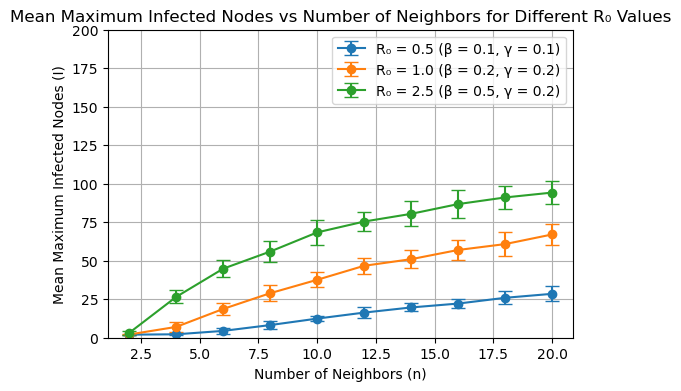

In [86]:
def ws_n_sweep(N, neighbors, p, beta, gamma, I0, t_span, num_runs):
    mean_max_values = []
    std_max_values = []

    for n in neighbors:
        max_I_values = []
        
        for _ in range(num_runs):  
            _, y_data = watts_strogatz(N, n, p, beta, gamma, I0, t_span)
            
            I_values = [data['I'] for data in y_data]
            
            # Get the maximum infected value in the current run
            max_I = max(I_values) if I_values else 0
            max_I_values.append(max_I)
        
        mean_max_I = np.mean(max_I_values) if max_I_values else 0
        std_max_I = np.std(max_I_values) if max_I_values else 0
        
        mean_max_values.append(mean_max_I)
        std_max_values.append(std_max_I)
    
    return mean_max_values, std_max_values


def plot_ws_n_sweep(N, neighbors, p, beta_values, gamma_values, I0, t_span, num_runs):
    plt.figure(figsize=(6, 4))
    
    for beta, gamma in zip(beta_values, gamma_values):
        
        mean_max_values, std_max_values = ws_n_sweep(N, neighbors, p, beta, gamma, I0, t_span, num_runs)
        
        R0 = beta/gamma
        label = f'R₀ = {R0:.1f} (β = {beta:.1f}, γ = {gamma:.1f})'
        
        plt.errorbar(neighbors, mean_max_values, yerr=std_max_values, fmt='-o', capsize=5, label=label)
    
    plt.xlabel("Number of Neighbors (n)") 
    plt.ylabel("Mean Maximum Infected Nodes (I)")
    plt.title("Mean Maximum Infected Nodes vs Number of Neighbors for Different R₀ Values")
    plt.legend()  
    plt.grid(True)
    plt.ylim(0, N)  
    plt.show()


def ws_n_vs_R0(N, neighbors, p, I0, t_span, num_runs, R0_values, gamma_values):
    beta_values = [R0 * gamma for R0, gamma in zip(R0_values, gamma_values)]
    
    plot_ws_n_sweep(N, neighbors, p, beta_values, gamma_values, I0, t_span, num_runs)


# Example Usage
N = 200
neighbors = np.arange(2, 22, 2)
p = 0.1 # Rewiring probability is fixed for now
R0_values = [0.5, 1.0, 2.5] 
gamma_values = [0.1, 0.2, 0.2]
I0 = 0.01
t_span = 50
num_runs = 50

ws_n_vs_R0(N, neighbors, p, I0, t_span, num_runs, R0_values, gamma_values)



## Erdos-Reyni

In [89]:
def erdos_reyni(N, p, beta, gamma, I0, t_span):
    """ 
    A random network model that generates edges (paths) between nodes 
    randomly. We run sir once on this network.

    
    """
    
    # Construct E-R Network
    er_graph = nx.erdos_renyi_graph(N, p)

    model = ep.SIRModel(er_graph)

    config = mc.Configuration()
    config.add_model_parameter('beta', beta)
    config.add_model_parameter('gamma', gamma)
    config.add_model_parameter("fraction_infected", I0)

    model.set_initial_status(config)

    # Simulate the model
    iterations = model.iteration_bunch(t_span)

    # Extract number of S, I, R nodes for each iteration
    y_data = []  # List to hold S, I, R counts for each iteration

    for iteration in iterations:
        # Get the status of nodes
        status = iteration['status']
        
        # Initialize counts
        S_count = 0
        I_count = 0
        R_count = 0
        
        # Count S, I, R based on status
        for _, state in status.items():
            if state == 0:  # Susceptible
                S_count += 1
            elif state == 1:  # Infected
                I_count += 1
            elif state == 2:  # Recovered
                R_count += 1
        
        # Append counts to the list
        y_data.append({'S': S_count, 'I': I_count, 'R': R_count})

    return iterations, y_data  # Return both iterations and status counts


N = 1000  # Number of nodes
p = 0.01  # Probability for edge creation
t_span = 200

results = erdos_reyni(N, p, beta, gamma, I0, t_span)
print(results)

([{'iteration': 0, 'status': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 1, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 0, 103: 0, 104: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 0, 119: 0, 120: 0, 121: 0, 122: 0, 123: 0, 124: 0, 125: 0, 126: 0, 127: 0, 128: 0, 129: 0, 130: 0, 131: 0, 132: 0, 133: 0, 134: 0, 

## Run SIR Sweep on Random (Erdos-Reyni) Network

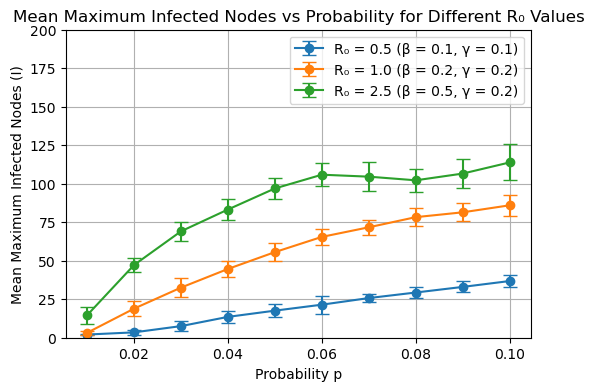

In [78]:
def er_probability_sweep(N, probabilities, beta, gamma, I0, t_span, num_runs):
    mean_max_values = []  
    std_max_values = []   

    for p in probabilities:
        max_I_values = []  
        
        for _ in range(num_runs):  
            _, y_data = erdos_reyni(N, p, beta, gamma, I0, t_span)
            
            I_values = [data['I'] for data in y_data]
            
            max_I = max(I_values) if I_values else 0
            max_I_values.append(max_I)
        
        mean_max_I = np.mean(max_I_values) if max_I_values else 0
        std_max_I = np.std(max_I_values) if max_I_values else 0
        
     
        mean_max_values.append(mean_max_I)
        std_max_values.append(std_max_I)
    
    return mean_max_values, std_max_values  


def plot_er_prob_sweep(N, probabilities, beta_values, gamma_values, I0, t_span, 
                       num_runs):
    plt.figure(figsize=(6, 4))
    
    for beta, gamma in zip(beta_values, gamma_values):
        
        mean_max_values, std_max_values = er_probability_sweep(N, probabilities, beta, gamma, I0, t_span, num_runs)
        
        R0 = beta / gamma
        label = f'R₀ = {R0:.1f} (β = {beta:.1f}, γ = {gamma:.1f})'
        
        plt.errorbar(probabilities, mean_max_values, yerr=std_max_values, 
                     fmt='-o', capsize=5, label=label)
    
    plt.xlabel("Probability p") 
    plt.ylabel("Mean Maximum Infected Nodes (I)")
    plt.title("Mean Maximum Infected Nodes vs Probability for Different R₀ Values")
    plt.legend()  
    plt.grid(True)
    plt.ylim(0, N)  
    plt.show()


def er_prob_vs_R0(N, probabilities, I0, t_span, num_runs, R0_values, gamma_values):
    beta_values = [R0 * gamma for R0, gamma in zip(R0_values, gamma_values)]
    
    plot_er_prob_sweep(N, probabilities, beta_values, gamma_values, I0, t_span, num_runs)



N = 200
probabilities = np.linspace(0.01, 0.1, 10)  
R0_values = [0.5, 1.0, 2.5]  
gamma_values = [0.1, 0.2, 0.2]  
I0 = 0.01
t_span = 50
num_runs = 50

er_prob_vs_R0(N, probabilities, I0, t_span, num_runs, R0_values, gamma_values)



## Generating Networks and Examining Network Statistics

In [69]:
def gen_nets(nettype, N, m_vals, p_vals, r_vals, num_runs, k=5):

    """
    Generate networks of specified types and calculate degree statistics and clustering coefficients.

    Parameters:
    nettype (str): Type of the network to generate ('BA' for Barabási–Albert, 
                   'ER' for Erdös-Renyi, 'WS' for Watts-Strogatz).
    N (int): Number of nodes in the network.
    m_vals (list): List of m values for Barabási–Albert networks (number of edges to attach from a new node).
    p_vals (list): List of p values for Erdös-Renyi networks (probability of connecting two edges).
    r_vals (list): List of r values for Watts-Strogatz networks (probability of rewiring an existing edge).
    num_runs (int): Number of times to run the network generation to gather statistics.
    k (int, optional): Number of nearest neighbors each node is connected to in Watts-Strogatz networks. Default is 5.

    Returns:
    dict: A dictionary containing the following keys and their respective values:
        - 'mean_min_degrees': List of mean minimum degrees for each m/p/r value.
        - 'std_min_degrees': List of standard deviations of minimum degrees for each m/p/r value.
        - 'mean_max_degrees': List of mean maximum degrees for each m/p/r value.
        - 'std_max_degrees': List of standard deviations of maximum degrees for each m/p/r value.
        - 'mean_degrees': List of mean degrees for each m/p/r value.
        - 'std_degrees': List of standard deviations of degrees for each m/p/r value.
        - 'mean_clustering_coeffs': List of mean clustering coefficients for each m/p/r value.
        - 'std_clustering_coeffs': List of standard deviations of clustering coefficients for each m/p/r value.
    """
    
    mean_min_degrees = []
    std_min_degrees = []
    
    mean_max_degrees = []
    std_max_degrees = []
    
    mean_degrees = []
    std_degrees = []
    
    mean_clustering_coeffs = []  
    std_clustering_coeffs = []    

    if nettype == 'BA':

        for m in m_vals:
            min_degrees = []
            max_degrees = []
            degree_sums = []
            clustering_coeffs = []  

            for _ in range(num_runs):
                ba_net = nx.barabasi_albert_graph(N, m)
                
                degrees = [deg for _, deg in ba_net.degree()]

                min_degrees.append(min(degrees))
                max_degrees.append(max(degrees))
                degree_sums.append(np.mean(degrees))  
                clustering_coeffs.append(nx.average_clustering(ba_net))  
                
            mean_min_degrees.append(np.mean(min_degrees))
            std_min_degrees.append(np.std(min_degrees))
            
            mean_max_degrees.append(np.mean(max_degrees))
            std_max_degrees.append(np.std(max_degrees))

            mean_degrees.append(np.mean(degree_sums))
            std_degrees.append(np.std(degree_sums))

            mean_clustering_coeffs.append(np.mean(clustering_coeffs))  
            std_clustering_coeffs.append(np.std(clustering_coeffs))  

    elif nettype == 'ER':
        
        mean_min_degrees = []
        std_min_degrees = []
        
        mean_max_degrees = []
        std_max_degrees = []
        
        mean_degrees = []
        std_degrees = []
        
        mean_clustering_coeffs = []  
        std_clustering_coeffs = []    

        for p in p_vals:
            min_degrees = []
            max_degrees = []
            degree_sums = []
            clustering_coeffs = []  

            for _ in range(num_runs):
                er_net = nx.erdos_renyi_graph(N, p)
                
                degrees = [deg for _, deg in er_net.degree()]

                min_degrees.append(min(degrees))
                max_degrees.append(max(degrees))
                degree_sums.append(np.mean(degrees))  
                clustering_coeffs.append(nx.average_clustering(er_net))  
                
            mean_min_degrees.append(np.mean(min_degrees))
            std_min_degrees.append(np.std(min_degrees))
            
            mean_max_degrees.append(np.mean(max_degrees))
            std_max_degrees.append(np.std(max_degrees))

            mean_degrees.append(np.mean(degree_sums))
            std_degrees.append(np.std(degree_sums))

            mean_clustering_coeffs.append(np.mean(clustering_coeffs))  
            std_clustering_coeffs.append(np.std(clustering_coeffs))  
    
    elif nettype == 'WS':


        mean_min_degrees = []
        std_min_degrees = []
        
        mean_max_degrees = []
        std_max_degrees = []
        
        mean_degrees = []
        std_degrees = []
        
        mean_clustering_coeffs = []  
        std_clustering_coeffs = []    

        for r in r_vals:
            min_degrees = []
            max_degrees = []
            degree_sums = []
            clustering_coeffs = []  

            for _ in range(num_runs):
                
                ws_net = nx.watts_strogatz_graph(N, k, r)
                
                degrees = [deg for _, deg in ws_net.degree()]

                min_degrees.append(min(degrees))
                max_degrees.append(max(degrees))
                degree_sums.append(np.mean(degrees))  
                clustering_coeffs.append(nx.average_clustering(ws_net))  
                
            mean_min_degrees.append(np.mean(min_degrees))
            std_min_degrees.append(np.std(min_degrees))
            
            mean_max_degrees.append(np.mean(max_degrees))
            std_max_degrees.append(np.std(max_degrees))

            mean_degrees.append(np.mean(degree_sums))
            std_degrees.append(np.std(degree_sums))

            mean_clustering_coeffs.append(np.mean(clustering_coeffs))  
            std_clustering_coeffs.append(np.std(clustering_coeffs))  
            
    return {
        'mean_min_degrees': mean_min_degrees,
        'std_min_degrees': std_min_degrees,
        'mean_max_degrees': mean_max_degrees,
        'std_max_degrees': std_max_degrees,
        'mean_degrees': mean_degrees,
        'std_degrees': std_degrees,
        'mean_clustering_coeffs': mean_clustering_coeffs,  
        'std_clustering_coeffs': std_clustering_coeffs      
    }


def plot_degree_stats(nettype, N, m_vals, p_vals, r_vals, num_runs, k=5):

    """
    Plot degree statistics for generated networks of specified types.

    Parameters:
    nettype (str): Type of the network to plot ('BA' for Barabási–Albert, 
                   'ER' for Erdös-Renyi, 'WS' for Watts-Strogatz).
    N (int): Number of nodes in the network.
    m_vals (list): List of m values for Barabási–Albert networks (number of edges to attach from a new node).
    p_vals (list): List of p values for Erdös-Renyi networks (probability of connecting two edges).
    r_vals (list): List of r values for Watts-Strogatz networks (probability of rewiring an existing edge).
    num_runs (int): Number of times to run the network generation to gather statistics.
    k (int, optional): Number of nearest neighbors each node is connected to in Watts-Strogatz networks. Default is 5.

    Returns:
    None
    """
    
    results = gen_nets(nettype, N, m_vals, p_vals, r_vals, num_runs, k=5)
    
    mean_min_degrees = results['mean_min_degrees']
    std_min_degrees = results['std_min_degrees']
    mean_max_degrees = results['mean_max_degrees']
    std_max_degrees = results['std_max_degrees']
    mean_degrees = results['mean_degrees']
    std_degrees = results['std_degrees']
    
    plt.figure(figsize=(8, 4))

    

    if nettype == 'BA':
        
        plt.errorbar(m_vals, mean_min_degrees, yerr=std_min_degrees, fmt='o', capsize=5, label='Mean Min Degree', color='blue')

        plt.errorbar(m_vals, mean_max_degrees, yerr=std_max_degrees, fmt='o', capsize=5, label='Mean Max Degree', color='green')

        plt.errorbar(m_vals, mean_degrees, yerr=std_degrees, fmt='o', capsize=5, label='Mean Degree', color='red')



        plt.xlabel("m (Number of edges to attach from a new node)")
        plt.title("Mean Min, Max, and Overall Degree vs m in Barabási–Albert Networks")
        

    elif nettype == 'ER':
        plt.errorbar(p_vals, mean_min_degrees, yerr=std_min_degrees, fmt='o', capsize=5, label='Mean Min Degree', color='blue')

        plt.errorbar(p_vals, mean_max_degrees, yerr=std_max_degrees, fmt='o', capsize=5, label='Mean Max Degree', color='green')

        plt.errorbar(p_vals, mean_degrees, yerr=std_degrees, fmt='o', capsize=5, label='Mean Degree', color='red')


        plt.xlabel("p (Probability of connecting two edges)")
        plt.title("Mean Min, Max, and Overall Degree vs p in Erdös–Renyi Networks")

    elif nettype == 'WS':
        plt.errorbar(r_vals, mean_min_degrees, yerr=std_min_degrees, fmt='o', capsize=5, label='Mean Min Degree', color='blue')

        plt.errorbar(r_vals, mean_max_degrees, yerr=std_max_degrees, fmt='o', capsize=5, label='Mean Max Degree', color='green')

        plt.errorbar(r_vals, mean_degrees, yerr=std_degrees, fmt='o', capsize=5, label='Mean Degree', color='red')


        plt.xlabel("r (Probability of rewiring an exisint edge)")
        plt.title("Mean Min, Max, and Overall Degree vs r in Watts-Strogatz Networks")


    plt.ylabel("Degree")
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_clustering_stats(nettype, N, m_vals, p_vals, r_vals, num_runs, k=5):

    """
    Plot clustering coefficient statistics for generated networks of specified types.

    Parameters:
    nettype (str): Type of the network to plot ('BA' for Barabási–Albert, 
                   'ER' for Erdös-Renyi, 'WS' for Watts-Strogatz).
    N (int): Number of nodes in the network.
    m_vals (list): List of m values for Barabási–Albert networks (number of edges to attach from a new node).
    p_vals (list): List of p values for Erdös-Renyi networks (probability of connecting two edges).
    r_vals (list): List of r values for Watts-Strogatz networks (probability of rewiring an existing edge).
    num_runs (int): Number of times to run the network generation to gather statistics.
    k (int, optional): Number of nearest neighbors each node is connected to in Watts-Strogatz networks. Default is 5.

    Returns:
    None: This function generates and displays a plot of the clustering coefficients.
    """
    
    results = gen_nets(nettype, N, m_vals, p_vals, r_vals, num_runs, k=5)
    mean_clustering_coeffs = results['mean_clustering_coeffs']
    std_clustering_coeffs = results['std_clustering_coeffs']


    plt.figure(figsize=(8, 4))

    
    
    if nettype == 'BA':
        plt.xlabel("m (Number of edges to attach from a new node)")
        plt.title("Mean Clustering Coefficient vs m in Barabási–Albert Networks")
        bar_width = 0.4  
        bar_positions = np.arange(len(m_vals))  
        plt.bar(bar_positions, mean_clustering_coeffs, yerr=std_clustering_coeffs, width=bar_width, alpha=0.6, color='orange', label='Mean Clustering Coefficient')
        plt.xticks(bar_positions + bar_width / 2, m_vals)  
    
    elif nettype == 'ER':
        plt.xlabel("p (Probability of connecting two edges)")
        plt.title("Mean Clustering Coefficient vs p in Erdös-Renyi Networks")
        bar_width = 0.4  
        bar_positions = np.arange(len(p_vals))  
        plt.bar(bar_positions, mean_clustering_coeffs, yerr=std_clustering_coeffs, width=bar_width, alpha=0.6, color='orange', label='Mean Clustering Coefficient')
        plt.xticks(bar_positions + bar_width / 2, p_vals) 

    elif nettype == 'WS':
        plt.xlabel("r (Probability of rewiring an exisint edge)")
        plt.title("Mean Clustering Coefficient vs r in Watts-Strogatz Networks")
        bar_width = 0.4  
        bar_positions = np.arange(len(r_vals))  
        plt.bar(bar_positions, mean_clustering_coeffs, yerr=std_clustering_coeffs, width=bar_width, alpha=0.6, color='orange', label='Mean Clustering Coefficient')
        plt.xticks(bar_positions + bar_width / 2, r_vals) 



    plt.ylabel("Clustering Coefficient")
    plt.legend()
    plt.grid(True)
    plt.show()


N = 300
# NOTe FRED: same for sweeps
m_vals = np.arange(2, 23, 2)
p_vals = np.linspace(0.01, 0.1, 10)
r_vals = np.linspace(0.1, 0.9, 10)
num_runs = 50
    

### BA-Network Stats

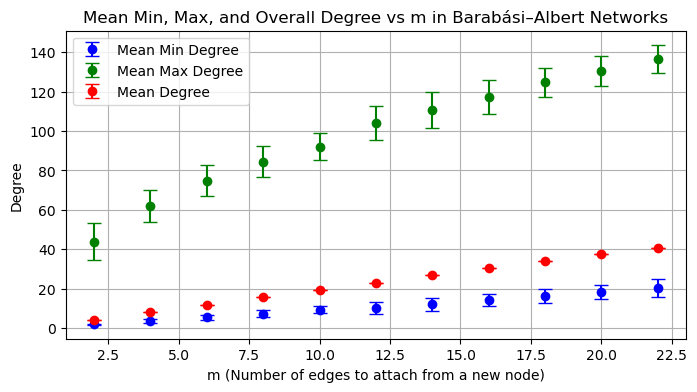

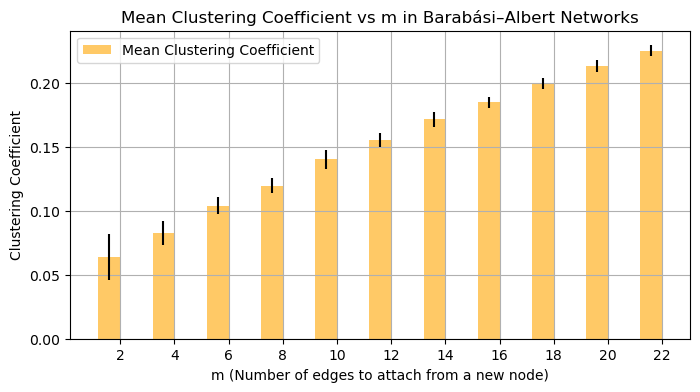

In [64]:
plot_degree_stats('BA', N, m_vals, p_vals, r_vals, num_runs)
plot_clustering_stats('BA', N, m_vals, p_vals, r_vals, num_runs)

## ER Results

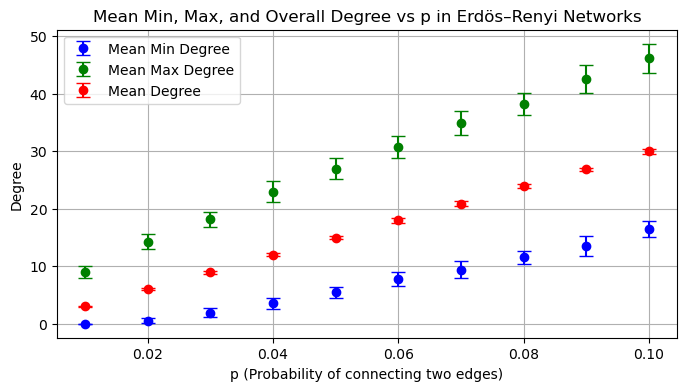

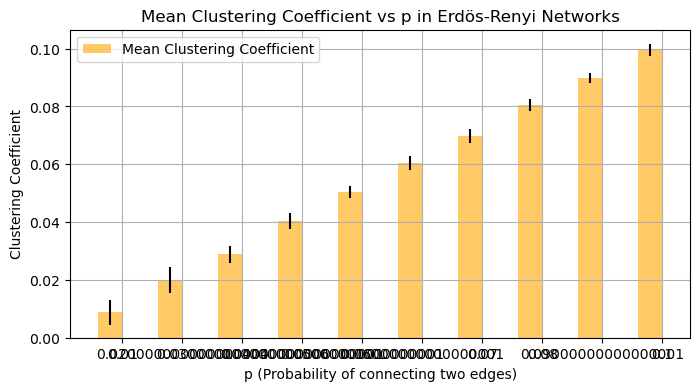

In [72]:
plot_degree_stats('ER', N, m_vals, p_vals, r_vals, num_runs)
plot_clustering_stats('ER', N, m_vals, p_vals, r_vals, num_runs)

## WS Results

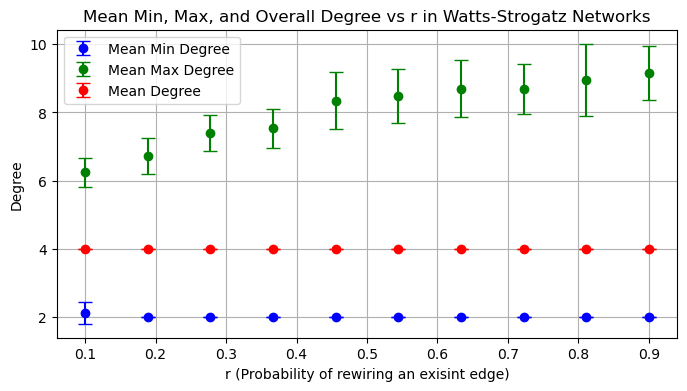

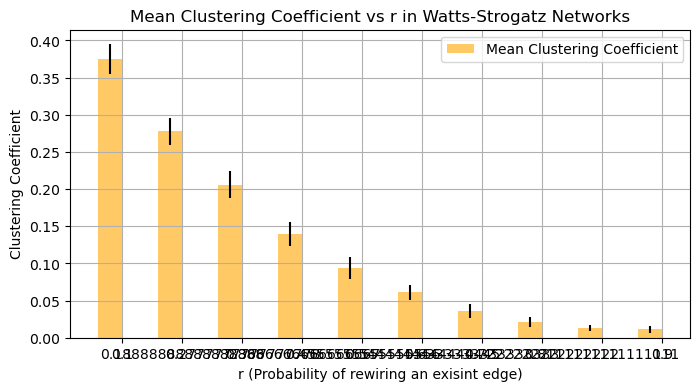

In [71]:
plot_degree_stats('WS', N, m_vals, p_vals, r_vals, num_runs)
plot_clustering_stats('WS', N, m_vals, p_vals, r_vals, num_runs)

## Dynamic Vaccination Campaign

To Do:
1. load in sociopatterns dataset (NDlib and network X)
    If i open the data in excel, the data structure is such that the first row and column signify the nodes. nodes from 1 to 374. All cells in between signify if there is an edge between the nodes. if the number is > 0 it means there is an edge, we can negate how high since that is the weight which we are not looking at right now (identity matrix)

    1 means infected, 0 means susceptible, 2 means recovered

    In NDlib 'Recovered' is 'Removed'

2. can we test and vaccinate at the same iteration or not
    we assume we can!

3. make extra graph of known information

In [148]:
#np.random.seed()


def load_sociopatterns():
    edge_list = pd.read_csv("transmission_network.csv", delimiter=';', index_col=0)

    graph = nx.Graph()

    # Adds all nodes to the graph
    graph.add_nodes_from(edge_list.index.tolist())

    # Adds edges between nodes if their weight is higher than 0
    for node_i, row in edge_list.iterrows():
        for node_j, value in row.items():
            if value > 0:
                graph.add_edge(int(node_i), int(node_j))
    return graph
    

def initiate_model(graph, beta, gamma):
    model = ep.SIRModel(graph)
    config = mc.Configuration()
    config.add_model_parameter('beta', beta)
    config.add_model_parameter('gamma', gamma)

    # Randomly assigns 5 nodes to get infected
    infected = 5
    infected_nodes = (np.random.choice(graph.nodes(), size=infected, replace=False)).tolist()
    config.add_model_initial_configuration('Infected', infected_nodes)
    model.set_initial_status(config)

    return model


def update_sir_model(model, iterations):
    model.iteration_bunch(iterations)  
    return model



def test_nodes_(model):
    """Tests if a node is infected"""
    return


def run_model(max_tests):
    tests = 200

    # The actual data
    graph = load_sociopatterns()

    # The known data
    graph_known = load_sociopatterns()

    return


def vac_nodes():
    return


beta = 0.01
gamma = 0.005
test_max = 10
vac_budget = 5
test_accuracy = 1.0

graph = load_sociopatterns()
initiate_model(graph, beta, gamma)

[1847, 1599, 1554, 1711, 1614]
The following nodes have been correctly infected: [1847, 1599, 1554, 1711, 1614]
Nodes infected after 10 iterations: [1549, 1599, 1554, 1688, 1772, 1614, 1711, 1786]
